In [2]:
import sys
sys.path.append('../')
import covasim as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as pl
import sciris as sc
import numpy as np
import scipy
from scipy.stats import norm, bernoulli
from collections import Counter,OrderedDict


In [12]:
class demographic_masking(cv.Intervention):
  def __init__(self,mask_eff=None,maskprob_ub=None,maskprob_lb=None,mean=None,std=None,*args,**kwargs):
    super().__init__(**kwargs)
    self.mask_eff         = mask_eff # mask effectiveness
    self.maskprob_ub      = maskprob_ub # probability of masking upper bound
    self.maskprob_lb      = maskprob_lb # probability of masking lower bound
    self.mean             = mean # mean of normal distribution used for beta1 in logit fucntion
    self.std              = std # standard deviation of normal distribution used for beta1 in logit function
    self.t                = [] # track each time step
    return

  def initialize(self,sim):
    super().initialize()
    ppl             = sim.people # shorten sim.people
    self.pop        = len(ppl)
    self.child      = np.logical_and(ppl.age > 2, ppl.age <= 9) # set children as agents aged 2 to 9
    self.adolescent = np.logical_and(ppl.age > 9, ppl.age <= 19) # set adolescent as agents aged 10 to 19
    self.adult      = np.logical_and(ppl.age > 19, ppl.age <= 69) # set adult as agents aged 20 to 69
    self.senior     = np.logical_and(ppl.age > 69, ppl.age <= 79) # set senior as agents aged 70 to 79
    self.supsenior  = ppl.age > 79 # set supersenior as agents aged 79+
    self.male       = ppl.sex == 1 # set male agents
    self.female     = ppl.sex == 0 # set female agents
    return

  def apply(self,sim):
    ppl                          = sim.people
    ppl.rel_sus[self.child]      = 0.34
    ppl.rel_sus[self.adolescent] = 0.67
    ppl.rel_sus[self.adult]      = 1.00
    ppl.rel_sus[self.senior]     = 1.24
    ppl.rel_sus[self.supsenior]  = 1.47
    
    num_dead      = ppl.dead.sum() # record number of agents dead at timestep t
    num_diagnosed = (ppl.diagnosed & ppl.infectious).sum() # record number of agents diagnosed at timestep t
    self.x        = num_dead + num_diagnosed # set x equal to number of agents diagnosed and dead
    self.norm     = norm.rvs(loc=self.mean,scale=self.std,size=self.pop) # set normal distrubution array of values for beta1 in logit function
    self.norm_f   = norm.rvs(loc=1.14,scale=0.15,size=self.pop) # set normal distribution array of values for masking probability multiplier for female agents

    uids = np.array(sim.people.uid)

    sexs = np.array(sim.people.sex)
    sexs = np.array(self.male,1,sexs)
    sexs = np.where(self.female,self.norm_f,sexs)

    ages = np.array(sim.people.age)
    ages = np.where(self.child,0.34,ages)
    ages = np.where(self.adolescent,0.67,ages)
    ages = np.where(self.adult,1.00,ages)
    ages = np.where(self.senior,1.24,ages)
    ages = np.where(self.supsenior,1.47,ages)

    contacts_h = np.bincount(ppl.contacts[0][0])
    h_array    = np.pad(contacts_h,(0,len(uids)-len(contacts_h)),mode='constant')
    contacts_s = np.bincount(ppl.contacts[1][0])
    s_array    = np.pad(contacts_s,(0,len(uids)-len(contacts_s)),mode='constant')
    contacts_w = np.bincount(ppl.contacts[2][0])
    w_array    = np.pad(contacts_w,(0,len(uids)-len(contacts_w)),mode='constant')
    contacts_c = np.bincount(ppl.contacts[3][0])
    c_array    = np.pad(contacts_c,(0,len(uids)-len(contacts_c)),mode='constant')
    contacts   = h_array + s_array + w_array + c_array

    p = np.exp((0.0001*contacts)+(self.norm*ages)*(self.x/self.pop)-(0.05*sim.t))
    p = sexs*(p/1+p)-0.5
    p = np.clip(p,self.maskprob_lb,self.maskprob_ub)

    masking = bernoulli.rvs(p=p,size=len(p))
    global num_masking
    num_masking = np.sum(masking)

    ppl.rel_sus = np.where(masking,self.mask_eff*ppl.rel_sus,ppl.rel_sus)
    return

In [5]:
tp = cv.test_prob(symp_prob=0.1,asymp_prob=0.001,symp_quar_prob=0.3,asymp_quar_prob=0.3,quar_policy='daily')
dm = demographic_masking(mask_eff=0.6,maskprob_ub=0.75,maskprob_lb=0.00,mean=100,std=50)

Initializing sim with 50000 people for 150 days
  Running "masking": 2020-03-01 ( 0/150) (0.30 s)  ———————————————————— 1%
  Running "masking": 2020-03-11 (10/150) (1.41 s)  •——————————————————— 7%
  Running "masking": 2020-03-21 (20/150) (2.63 s)  ••—————————————————— 14%
  Running "masking": 2020-03-31 (30/150) (3.95 s)  ••••———————————————— 21%
  Running "masking": 2020-04-10 (40/150) (5.35 s)  •••••——————————————— 27%
  Running "masking": 2020-04-20 (50/150) (6.61 s)  ••••••—————————————— 34%
  Running "masking": 2020-04-30 (60/150) (7.90 s)  ••••••••———————————— 40%
  Running "masking": 2020-05-10 (70/150) (9.23 s)  •••••••••——————————— 47%
  Running "masking": 2020-05-20 (80/150) (10.59 s)  ••••••••••—————————— 54%
  Running "masking": 2020-05-30 (90/150) (11.95 s)  ••••••••••••———————— 60%
  Running "masking": 2020-06-09 (100/150) (13.23 s)  •••••••••••••——————— 67%
  Running "masking": 2020-06-19 (110/150) (14.46 s)  ••••••••••••••—————— 74%
  Running "masking": 2020-06-29 (120

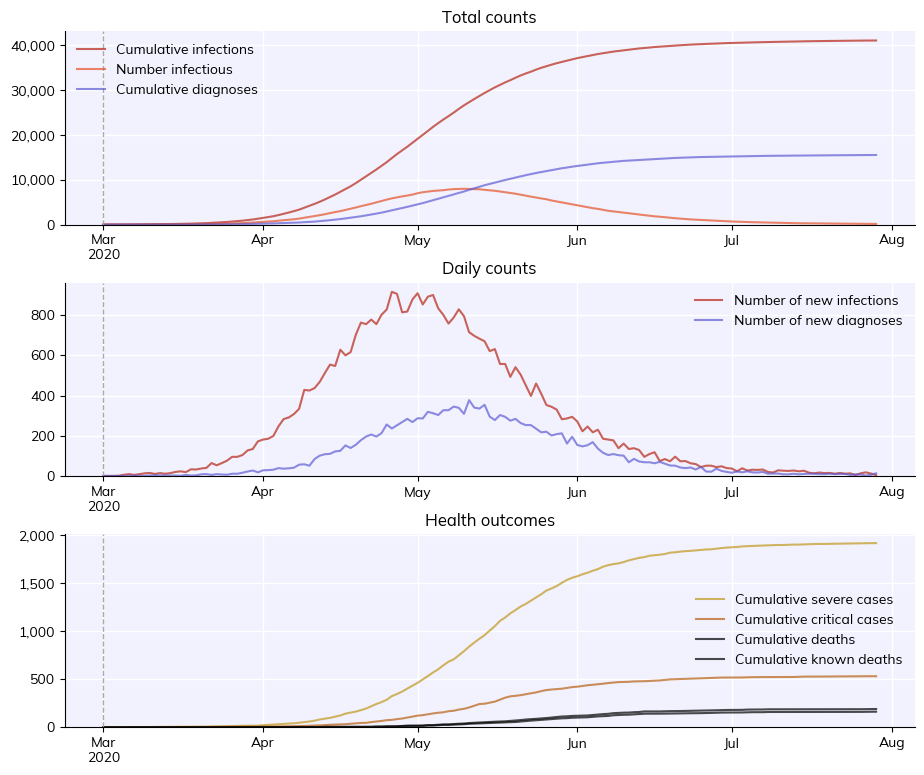

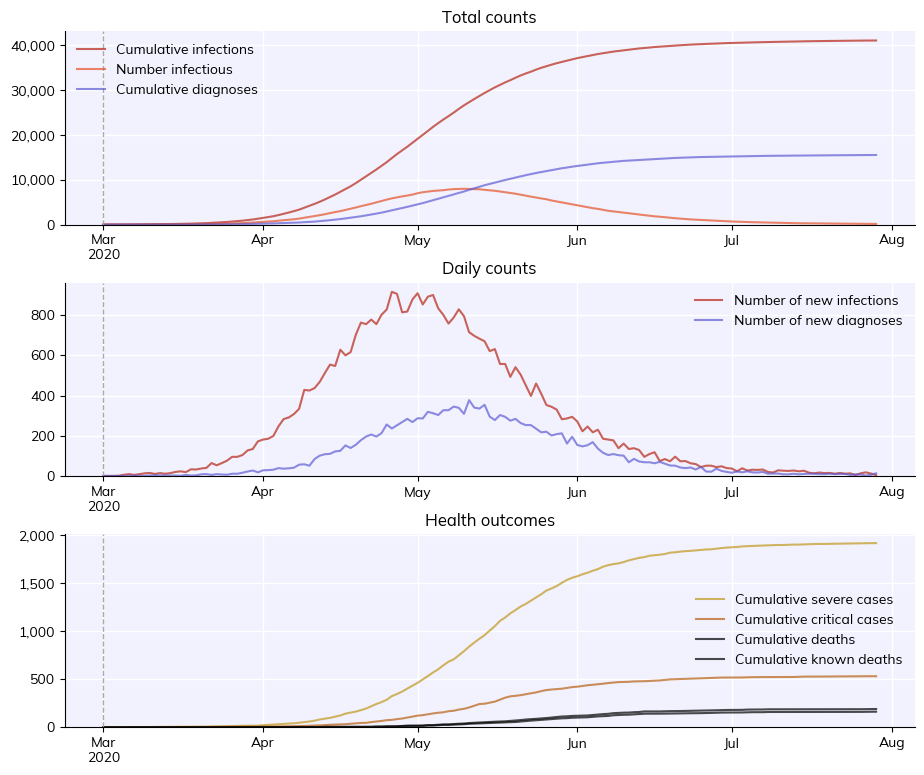

In [11]:

sim = cv.Sim(pop_size=50e3,n_days=150,interventions=[tp,dm],beta=0.023,label='masking',pop_type='hybrid')


sim.run().plot()